In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import dalex as dx
import shap
import pickle as pkl 

In [3]:
df = pd.read_csv("../data/preprocessed_data.csv")

In [4]:
X = df.drop(["is_canceled"], axis=1)
y = df["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [5]:
tuned_names = ["decision_tree", "random_forest", "xgb"]
tuned_models = dict()

for name in tuned_names:
    with open("../models/tuned/" + name, "rb") as file:
        tuned_models[name] = pkl.load(file)

explainers = dict()

for name, model in tuned_models.items():
    explainers[name] = dx.Explainer(model, X_train, y_train, label=name)

Preparation of a new explainer is initiated

  -> data              : 95368 rows 25 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 95368 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : decision_tree
  -> predict function  : <function yhat_proba_default at 0x000001D6F16FC700> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.371, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.000345, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 95368 rows 25 cols
  -> target variable   : Parameter 'y' was a pandas.Series.

In [6]:
preds = tuned_models["random_forest"].predict(X_test)
probs = tuned_models["random_forest"].predict_proba(X_test)

In [7]:
FN = np.where((preds != y_test) & (preds == 0))[0]
FP = np.where((preds != y_test) & (preds == 1))[0]
TN = np.where((preds == y_test) & (preds == 0))[0]
TP = np.where((preds == y_test) & (preds == 1))[0]

# False nagatives and False positives

# False negative

In [8]:
df_FN = X_test.iloc[FN, :]
df_FN["prob"] = probs[FN, 0]
df_FN.sort_values(by="prob", ascending=False, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [130]:
observation = df_FN.iloc[[0]].iloc[:, :-1]
print(observation.squeeze())

prediction = tuned_models["random_forest"].predict(observation)[0]

prob = tuned_models["random_forest"].predict_proba(observation)[0][prediction]

print(f'Predicted value for DT model for the selected observation: {prediction} ({prob}), real value: 1')

lead_time                                     181
arrival_date_week_number                       42
arrival_date_day_of_month                      11
stays_in_weekend_nights                         0
stays_in_week_nights                            2
total_nights                                    2
adults                                          1
children                                      0.0
babies                                          0
is_repeated_guest                               0
previous_cancellations                          0
previous_bookings_not_canceled                  0
agent                                       234.0
company                                       0.0
required_car_parking_spaces                     0
total_of_special_requests                       0
adr                                         120.0
adr_pp                                      120.0
arrival_date_month                        October
meal                                           BB


In [131]:
shap_FN = explainers["random_forest"].predict_parts(observation, type='shap', B=5)

In [132]:
shap_FN.plot()

## SHAP

In [19]:
observation = df_FN.iloc[:2, :-1]


In [118]:
num_cols = X_test.columns[~np.isin(X_test.columns.values, tuned_models["random_forest"]['preprocessor'].transformers_[1][2])]

In [119]:
cat_cols = tuned_models["random_forest"]['preprocessor'].transformers_[1][1]\
    ['onehot'].get_feature_names_out(tuned_models["random_forest"]['preprocessor'].transformers_[1][2])

In [123]:
cols = np.r_[num_cols, cat_cols]

In [128]:
explainer = shap.Explainer(tuned_models["random_forest"]["model"].predict, 
    tuned_models["random_forest"]['preprocessor'].transform(X_test), feature_names=cols

)
sv = explainer(tuned_models["random_forest"]['preprocessor'].transform(observation))

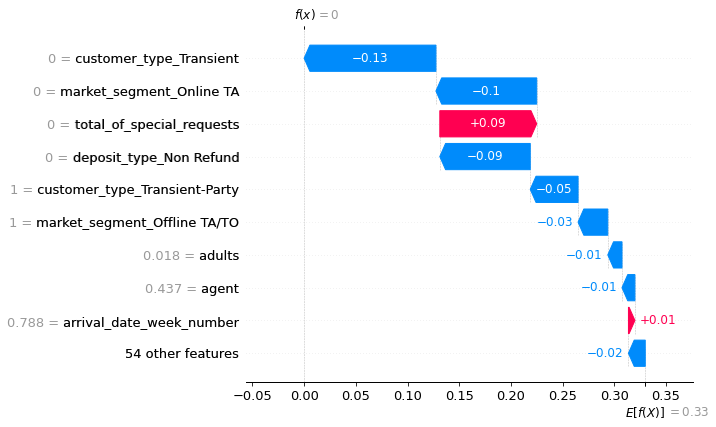

In [129]:
shap.plots.waterfall(sv[0])

## False positive

In [133]:
df_FP = X_test.iloc[FP, :]
df_FP["prob"] = probs[FP, 0]
df_FP.sort_values(by="prob", ascending=False, inplace=True)

C:\Users\mikol\AppData\Local\Temp/ipykernel_9908/1143494719.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

d:\Programy\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [134]:
observation = df_FP.iloc[[0]].iloc[:, :-1]
print(observation.squeeze())

prediction = tuned_models["random_forest"].predict(observation)[0]

prob = tuned_models["random_forest"].predict_proba(observation)[0][prediction]

print(f'Predicted value for the selected observation: {prediction} ({prob}), real value: 0')

lead_time                                 21
arrival_date_week_number                  53
arrival_date_day_of_month                 27
stays_in_weekend_nights                    2
stays_in_week_nights                       2
total_nights                               4
adults                                     2
children                                 2.0
babies                                     0
is_repeated_guest                          0
previous_cancellations                     0
previous_bookings_not_canceled             0
agent                                    9.0
company                                  0.0
required_car_parking_spaces                0
total_of_special_requests                  1
adr                                    187.0
adr_pp                                 46.75
arrival_date_month                  December
meal                                      BB
market_segment                     Online TA
distribution_channel                   TA/TO
reserved_r

In [135]:
shap_FP = explainers["random_forest"].predict_parts(observation, type='shap', B=5)

In [136]:
shap_FP.plot()

# The most valid predictions

In [31]:
valid = np.where(np.logical_or(probs>=0.95, probs<=0.05))[0]


# The closest to the decision boundary

In [ ]:
closest = np.where(np.logical_and(probs>=0.49, probs<=0.51))[0]
